# **Titanic comp: EDA, feature engineering & XGBoost** 

The aim of this kernel is to predict which passengers from the historical Titanic catastrophe survived based on raw personal data. 
The kernel may be useful as a reference for any data scientist wishing to review a complete walkthrough through all the steps involved in any machine learning algorithm.

**TABLE OF CONTENTS**

1. [Exploratory data analysis (EDA)](#section1)
2. [Cleaning of missing data](#section2)
3. [Feature engineering](#section3)
4. [Preparation of data](#section4)
5. [Parameter optimization of the XGB model](#section5)
6. [Final prediction and submit](#section6)
7. [Ad-hoc rules (optional](#section7)

First of all, we import all libraries we will use later on,

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import re
import warnings
warnings.filterwarnings('ignore')

# 1. Exploratory data analysis (EDA) <a id="section1"></a>

Proceed to read all files provided by Titanic's Kaggle competition, and print a subset to see how data is structured.

In [2]:
# Load files
gender_submission = pd.read_csv("../input/titanic/gender_submission.csv")
test = pd.read_csv("../input/titanic/test.csv")
train = pd.read_csv("../input/titanic/train.csv")

display(test.head(15))

# A brief statistical summary of the training dataset
display(train.describe())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Feature types observed from the displayed data:
* **Categorical**: Survived, Sex, and Embarked. 
* **Numeric**: Pclass, Age, Fare, SibSp and Parch.
* **Mixed**: Cabin

Let's now analyze the size of our train and test datasets, as well as an initial survey on male/female survival rate:

Train set shape:  (891, 12)
Test set shape:  (418, 11)
Percentage of females that survived:  0.7420382165605095
Percentage of males that survived:  0.18890814558058924


Text(0.5, 1.0, 'Survival count')

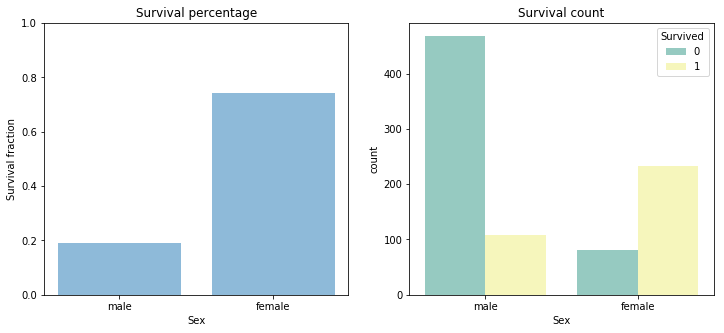

In [3]:
# Analyze the data shape
train_shape = train.shape
test_shape = test.shape
all_data = pd.concat([train,test], sort=False)
print("Train set shape: ", train_shape)
print("Test set shape: ", test_shape)

# Female/Male survival ratio is an obvious candidate to key feature
female_survival = len(train[(train.Sex=='female') & (train.Survived==1)])/len(train[(train.Sex=='female')])
male_survival = len(train[(train.Sex=='male') & (train.Survived==1)])/len(train[(train.Sex=='male')])
print("Percentage of females that survived: ", female_survival)
print("Percentage of males that survived: ", male_survival)

# Now we plot some plots about survival rates/counts
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].bar(['male', 'female'], [male_survival,female_survival], alpha = 0.5)
axes[0].set_xlabel('Sex')
axes[0].set_ylabel("Survival fraction")
axes[0].set_title('Survival percentage')
axes[0].set_ylim(0,1)

sns.countplot(x='Sex', hue='Survived', ax=axes[1], data=train, palette='Set3')
axes[1].set_title('Survival count')

**Observations**:

* There's a huge difference in the survival rate between males and females. The reason for this is the traditional behavior tendency summarized by *"women and children first"*, so that men were prone to stay out from rescue boats. Hence, the gender feature (Sex) will be critical for our prediction algorithm. 

## 1.1. Variable distributions <a id="section11"></a>
How other variables are distributed? This analysis allows to find  outliers and key behaviors,

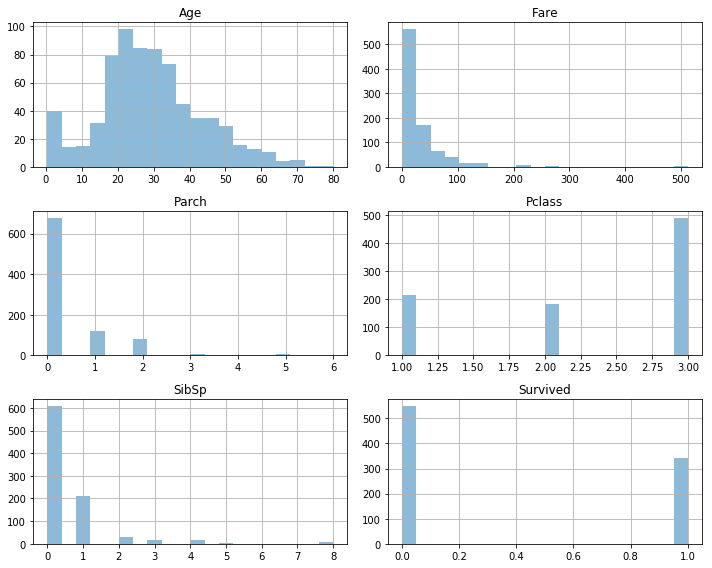

In [4]:
train.drop('PassengerId', axis=1).hist(bins=20, figsize=(10, 8), alpha=0.5)
plt.tight_layout()

**Observations**:
1. Age follows more or less normal distribution (for such a small dataset, <1000 passengers).
2. Fare distribution follows the expected exponentially decay. Typically wealth distributions are exponential.
3. There is almost the same number of 3rd class passengers than 1st and 2nd together.

## 1.2. Age distribution <a id="section12"></a>

Back in the 1900's, there was a big seggregation by sex in many aspects. Let's verify if this is true for our dataset:

Text(0.5, 1.0, 'Continuous distribution by sex')

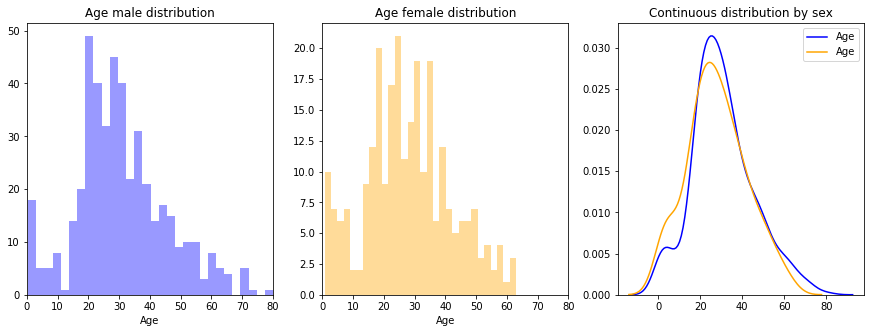

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.distplot(train[train['Sex']=='male']['Age'].dropna(), kde=False, color='blue', bins=30, ax=axes[0])
axes[0].set_title('Age male distribution')
axes[0].set_xlim(0, 80)

sns.distplot(train[train['Sex']=='female']['Age'].dropna(), kde=False, color='orange', bins=30, ax=axes[1])
axes[1].set_title('Age female distribution')
axes[1].set_xlim(0, 80)

sns.kdeplot(train[train['Sex']=='male']['Age'].dropna(), color='blue', ax=axes[2])
sns.kdeplot(train[train['Sex']=='female']['Age'].dropna(), color='orange', ax=axes[2])
axes[2].set_title('Continuous distribution by sex')

**Observations**:
1. There's a reasonable difference between age distribution shapes. Female distr. is roughly gaussian, while males distr. is more skewed
2. Females tend to be younger than males
3. Males age distribution has a longer tail, since there are older men passengers (>60 years)

## 1.3. Passenger class distribution (Pclass) <a id="section13"></a>

There are 3 main passenger classes in the dataset, which is a clear candidate of key feature for the survival rate. One would expect that higher class passengers survive more often than lower ones. 

Text(0, 0.5, '')

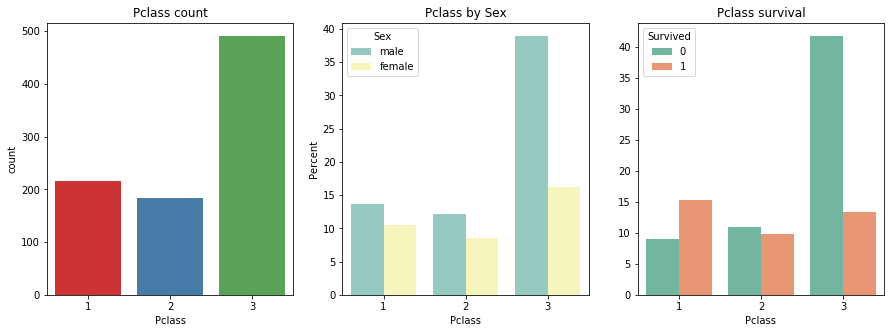

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.countplot(x='Pclass', data=train, ax=axes[0], palette='Set1')
axes[0].set_title('Pclass count')

sns.barplot(x='Pclass', y='Pclass', hue='Sex', data=train, ax=axes[1], palette='Set3', estimator=lambda x: len(x) / len(train) * 100)
axes[1].set(ylabel="Percent")
axes[1].set_title('Pclass by Sex')

sns.barplot(x='Pclass', y='Pclass', hue='Survived', data=train, ax=axes[2], palette='Set2', estimator=lambda x: len(x) / len(train) * 100)
axes[2].set_title('Pclass survival')
axes[2].set_ylabel('')

**Observations**:
1. As commented in section 2.1, there is almost the same number of 3rd class passengers than 1st and 2nd together
2. The difference between class passengers is larger in males than in females
3. Indeed, class type is fundamental for survival rate. The higher the class, the more likely you are to survive

## 1.4. Embarkation port <a id="section14"></a>

There are 3 informed embarcations: S = Southampton, C = Cherbourg and Q = Queenstown. This could be related to where passengers were located in the ship, or the order of the cabins assigned. 

Text(0, 0.5, '')

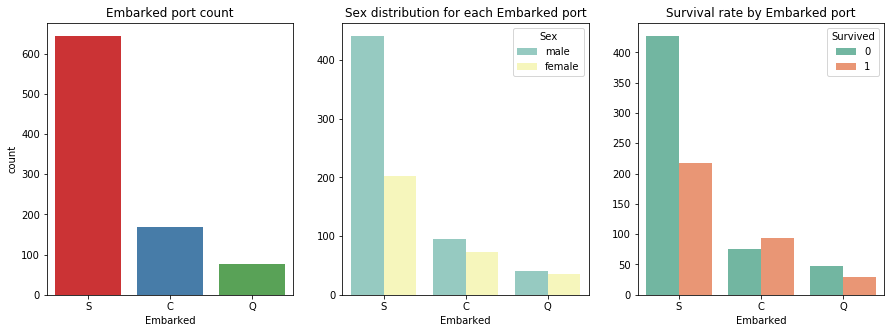

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.countplot(x='Embarked', data=train, ax=axes[0], palette='Set1')
axes[0].set_title('Embarked port count')

sns.countplot(x='Embarked', hue='Sex', data=train, ax=axes[1],  palette='Set3')
axes[1].set_title('Sex distribution for each Embarked port')
axes[1].set_ylabel('')

sns.countplot(x='Embarked', hue='Survived', data=train, ax=axes[2], palette='Set2')
axes[2].set_title('Survival rate by Embarked port')
axes[2].set_ylabel('')

**Observations**: 
1. Most people embarked in the first port, Southampton
2. The distribution of male/females are similar for all 3 ports
3. However, survival rates are strongly dependent on the port. People embarked in Cherbourg had better chances to survive than to die

## 1.5. Correlation matrix <a id="section15"></a>

Create a correlation matrix to detect dependencies between features. Print explicitly the correlation values for all features with respect to the target (Survived).

Correlations with Survived:
Survived          1.000000
Sex_female        0.543351
Fare              0.257307
Parch             0.081629
Parch_dummies     0.081629
PassengerId      -0.005007
SibSp            -0.035322
SibSp_dummies    -0.035322
Age              -0.077221
Pclass           -0.338481
Pclass_dummies   -0.338481
Sex_male         -0.543351
Name: Survived, dtype: float64
Data Exploration: Completed


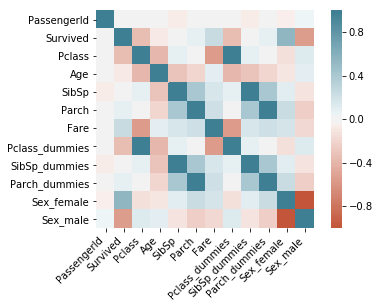

In [8]:
# Correlation matrix of relevant features
print("Correlations with Survived:")
features = ["Pclass", "Sex", "SibSp", "Parch"]
X = all_data[:len(train)].join(pd.get_dummies(all_data[:len(train)][features]), rsuffix="_dummies", sort=False)
corr = X.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
Highest_corr = corr.nlargest(30, 'Survived')['Survived']
print(Highest_corr)

print("Data Exploration: Completed")

It can be concluded that both the sex of the passenger and the fare paid for the ticket are the most important features for the survival of a person.

# 2. Clean missing data <a id="section2"></a>

In real life, almost all datasets you find have tons of missing data. To decide how to process missings, either by directly dropping a column with a lot of nulls or by rhardcoding certain values, may be critical for our final machine learning performance. 

In this section, we will cover only two features: 
* Fare (1 missing) 
* Embarked (2 missings)

The other two missing columns (Age -263 missings- and Cabin -1014 missings-) will be tackled in the next step (feature engineering), since they require more advanced techniques or custom features to deal with their missings.

In [9]:
# Look for missing data 
missings = {col:all_data[col].isnull().sum() for col in all_data.columns if all_data[col].isnull().sum()>0}
print("The following features contain missing values: ", missings)

## FARE ##
# Passenger with pass_id = 1044 has no Fare informed. He was 3rd class, let's replace his fare with the avg of 3rd class.
all_data_sorted_fare = all_data
all_data_sorted_fare.sort_values(by=['Fare'])
#print(all_data_sorted_fare)
all_data.set_value(all_data[all_data['PassengerId']==1044].index, 'Fare', all_data[all_data['Pclass']==3].Fare.mean())

## EMBARKED ##
# For the passengers without Embarked data, we will use the mode
all_data['Embarked'].fillna(all_data['Embarked'].mode()[0], axis=0, inplace=True)

## AGE ##
# 263 passengers have no age informed. To fill these values, we need some feature engineering (next step)

## CABIN ## 
# Most cabin values are missing. To fill these values, we need some feature engineering (next step)

print("Missing cleaning: Completed")

The following features contain missing values:  {'Survived': 418, 'Age': 263, 'Fare': 1, 'Cabin': 1014, 'Embarked': 2}
Missing cleaning: Completed


# 3. Feature engineering <a id="section3"></a>

Data exploration gave us some insight about how datasets are structured and which features could be more relevant for our model. Missing values from Fare and Embarked have been replaced, but but not those from Age and Cabin. Moreover, there's still room for improvement in our dataset, and in this step we will try to squeeze out all information available.

A brief summary of what we will do in this step:
* **Docker_num**. From the Cabin column.
* **Has_cabin_informed** (flag). From the Cabin column.
* **Title**. Specified in the passenger's name (i.e. Kelly, **Mr**. James). We will group some title as VIPS and Crew
* **Age missings**. Replace null values with the mean of the people with the same Title.
* **Age_cat**. Age groups may help to diferentiate even more people, adding a non-continuous dimension of the age
* **Fare_cat**. Same as Age, create bins of fare paid for the ticket
* **Relatives**. Compute the number of relatives, SibSp + Parch
* **Family_survival**. Compute families of passengers from last_name and fare information
* **Is_Alone** (flag). If Relatives=0, then Is_Alone=1
* **Skewness analysis**. Analyze Fare and Age distribution to see if they are highly non-normal. Apply corrections in this case, log(x)

In [10]:
## CABIN ##
# The letter of the cabin number is related to the docker of the ship (hypothesis). 
all_data['Docker_num'] = [cab[:1] if pd.notnull(cab) else "Unknown" for cab in all_data['Cabin']]
all_data['Has_cabin_informed'] = [1 if pd.notnull(cab) else 0 for cab in all_data['Cabin']]


## TITLE NAME ##
# Mr, Mrs, Miss, Master, etc, are indicative of person status. Hence, it's interesting to extract titles feature
all_data['Title'] = [re.search('\,(.*)\.', name).group(1) for name in all_data['Name']]
all_data.set_value(all_data['PassengerId']==514, 'Title', ' Mrs')
dictionary_of_titles = {
    " Capt": "Crew",
    " Col": "Crew",
    " Major": "Crew",
    " Dr": "Crew",
    " Rev": "Crew",
    " Jonkheer": "VIP",
    " Don": "VIP",
    " Dona": "VIP",
    " Sir" : "VIP",
    " the Countess":"VIP",
    " Lady" : "VIP",
    " Mme": "Mrs",
    " Ms": "Miss",
    " Mrs" : "Mrs",
    " Mlle": "Miss",
    " Miss" : "Miss",
    " Mr" : "Mr",
    " Master" : "Master"
}
all_data['Title'] = all_data.Title.map(dictionary_of_titles)


## AGE ##
# Function to fill missing age depending on title
def fill_missing_age_title(all_data):
    # Average age for each title:
    class_age_female_miss = all_data[(all_data['Title']=='Miss')]['Age'].dropna().mean()
    class_age_female_mrs = all_data[(all_data['Title']=='Mrs')]['Age'].dropna().mean()
    class_age_male_master = all_data[(all_data['Title']=='Master')]['Age'].dropna().mean()
    class_age_male_mr = all_data[(all_data['Title']=='Mr')]['Age'].dropna().mean()
    #class_age_male_crew = all_data[(all_data['Title']=='Crew')]['Age'].dropna().mean()
    #class_age_male_vip = all_data[(all_data['Title']=='VIP')]['Age'].dropna().mean()
    
    # We fill missing age from the average age of the same Title
    all_data[all_data['Age'].isnull()==True].head(5)
    all_data.set_value(all_data[(all_data['Age'].isnull()==True) & (all_data['Title']=='Miss')].index, 'Age', class_age_female_miss)
    all_data.set_value(all_data[(all_data['Age'].isnull()==True) & (all_data['Title']=='Mrs')].index, 'Age', class_age_female_mrs)
    all_data.set_value(all_data[(all_data['Age'].isnull()==True) & (all_data['Title']=='Master')].index, 'Age', class_age_male_master)
    all_data.set_value(all_data[(all_data['Age'].isnull()==True) & (all_data['Title']=='Mr')].index, 'Age', class_age_male_mr)
    #all_data.set_value(all_data[(all_data['Age'].isnull()==True) & (all_data['Title']=='Crew')].index, 'Age', class_age_male_crew)
    #all_data.set_value(all_data[(all_data['Age'].isnull()==True) & (all_data['Title']=='VIP')].index, 'Age', class_age_male_vip)
    
    return all_data
all_data = fill_missing_age_title(all_data)
        
    
## AGE CATEGORY ##
def age_cat(age):
    if age <= 15:
        return 1
    if age <= 35:
        return 2
    if age <= 55:
        return 3
    if age > 55:
        return 4
    else:
        return 0
all_data['Age_cat'] = all_data['Age'].apply(age_cat)
    
    
## FARE CATEGORY ##
def fare_cat(fare):
    if fare < 15:
        return 1
    if fare < 35:
        return 2
    if fare < 100:
        return 3
    if fare > 100:
        return 4
    else:
        return 0    
all_data['Fare_cat'] = all_data['Age'].apply(fare_cat)


## RELATIVES ##
# Compute number of relatives in the ship
all_data['Relatives'] = all_data['SibSp'] + all_data['Parch']


## FAMILIES ##
# Compute families based on surname and fare
def fill_families(all_data):
    all_data['Last_Name'] = all_data['Name'].apply(lambda x: str.split(x, ",")[0])

    # Random chance of surviving, 50%
    default_survival_chance = 0.5
    all_data['Family_Survival'] = default_survival_chance

    # Group data by last name and fare - looking for families
    for grp, grp_df in all_data[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                               'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):

        # If not equal to 1, a family is found 
        # Then work out survival chance depending on whether or not that family member survived
        if (len(grp_df) != 1):
            for ind, row in grp_df.iterrows():
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin == 0.0):
                    all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 0

    all_data['IsAlone'] = 0
    all_data.loc[all_data['Relatives'] == 0, 'IsAlone'] = 1 
    return all_data
all_data = fill_families(all_data)

# Let's take a look to our new features
all_data.head(5) 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,Docker_num,Has_cabin_informed,Title,Age_cat,Fare_cat,Relatives,Last_Name,Family_Survival,IsAlone
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,S,Unknown,0,Mr,2,2,1,Braund,0.5,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,C,1,Mrs,3,3,1,Cumings,0.5,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,S,Unknown,0,Miss,2,2,0,Heikkinen,0.5,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,S,C,1,Mrs,2,3,1,Futrelle,0.0,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,S,Unknown,0,Mr,2,3,0,Allen,0.5,1


## 3.1. Skewness analysis <a id="section31"></a>

Sometimes, numeric distributions do not follow a normal distribution but they are skewed (either positive or negative). This is important for several reasons, you can see a good thread for the House pricing competition in [here](https://stats.stackexchange.com/questions/299154/the-benefit-of-unskewing-skewed-data). To sum up let's say that skewness is import due to two main facts:
* Certain features should be interpreted (and computed) in a multiplicative way. For example, the relative  difference between 10€ and 100€ is much higher than between 10.010€ and 10.100€.
* A number of machine learning algorithms give better predictions for normally distributed data

Hence, it's good to check skewness in potential features, and eventually transform them if necessary (typically with a log transform, but there are many options). For us, both Fare and Age are candidates.

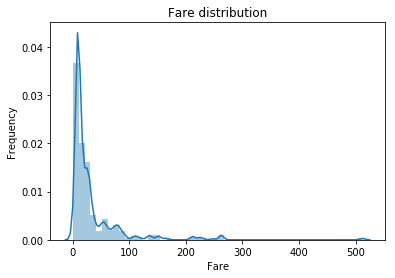

In [11]:
## FARE SKEWNESS ##
# Skewness and Kurtosis analysis for Fare. Apply log transform if skew is too high (see graph below)
sns.distplot(all_data['Fare'].dropna())
plt.ylabel('Frequency')
plt.title('Fare distribution')
#print("Skewness: %f" % all_data['Fare'].dropna().skew())
#print("Kurtosis: %f" % all_data['Fare'].dropna().kurt())
all_data['Fare']=all_data['Fare'].apply(lambda x: np.log(x))

Feature engineering: Completed


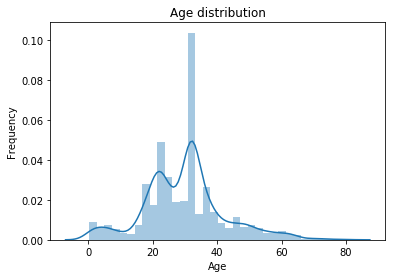

In [12]:
## FARE SKEWNESS ##
# Skewness and Kurtosis analysis for Age. Apply log transform if skew is too high
sns.distplot(all_data['Age'].dropna())
plt.ylabel('Frequency')
plt.title('Age distribution')
#print("Skewness: %f" % all_data['Fare'].dropna().skew())
#print("Kurtosis: %f" % all_data['Fare'].dropna().kurt())
all_data['Age']=all_data['Age'].apply(lambda x: np.log(x))
                
print("Feature engineering: Completed")

# 4. Preparation of data <a id="section4"></a>


Finally, let's proceed to split data, extract the target column and encode cateogorical data (One Hot).

Data split:
* Train (95% of the original train)
* Validation (5% of the original train)
* Test (original test passengers)

In [13]:
# Split again train/test
X = all_data[:len(train)]
X_test_full = all_data[len(train):]

# Split target variable
y = X.Survived
X.drop('Survived', axis=1, inplace=True)
print(len(all_data), len(X), len(X_test_full))

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.95, test_size=0.05, random_state=0)

# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype not in ['int64', 'float64']]
print("Low cardinality columns: ", low_cardinality_cols)

# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]
print("Numeric columns: ", numeric_cols)

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

1309 891 418
Low cardinality columns:  ['Sex', 'Embarked', 'Docker_num', 'Title']
Numeric columns:  ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Has_cabin_informed', 'Age_cat', 'Fare_cat', 'Relatives', 'Family_Survival', 'IsAlone']


# 5. Parameter optimization of the XGB model <a id="section5"></a>

In order to get the best of the possible scores, it's recommended some fine tunning of our model. I chose XGBoost as my machine learning model, and in this step we will perform a grid search of parameters to find the combination with best score over 3 cross validation folds.

In [14]:
def xgb_optimize(X_train, y_train):
    xgb1 = xgb()
    parameters = {'nthread':[1], #when use hyperthread, xgboost may become slower
                  'learning_rate': [.005, .004, .003, .002, .0009, 0.008], 
                  'max_depth': [4, 5, 6, 7],
                  'min_child_weight': [4, 5, 6],
                  'silent': [1],
                  'subsample': [0.5],
                  'colsample_bytree': [0.7],
                  'n_estimators': [1000, 2500, 5000, 7500]}

    xgb_grid = GridSearchCV(xgb1,
                            parameters,
                            cv = 3,
                            n_jobs = 5,
                            verbose=True)

    xgb_grid.fit(X_train, y_train.astype(int))

    print(xgb_grid.best_score_)
    print(xgb_grid.best_params_)
    
# Uncomment the call to the xgb_optimize function to perform a (very) time consuming grid search 
# xgb_optimize(X_train, y_train)

# 6. Prediction and submit <a id="section6"></a>

Finally, we know the set of parameters that optimize our score, and there is only pending the definitive prediction. 
You will se that I used a very trivial Pipeline, but this is just for best practices purposes.

In [15]:
# Define model with best MAE
model = xgb(colsample_bytree=0.7, learning_rate=0.0009, max_depth=6, min_child_weight=5, n_estimators=2500, 
                     nthread=1, silent=1, subsample=0.7, random_state=0, 
                     early_stopping_rounds = 10, eval_set=[(X_valid, y_valid)], verbose=False)

# Train and test the model

print("Let's the training begin. Plase wait.")

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('model', model)])
my_pipeline.fit(X_train, y_train.astype(int))

print("Training finished! Now let's predict test values.")

preds_test = my_pipeline.predict(X_test)

# Save test predictions to file
output = pd.DataFrame({'PassengerId': X_test.index+892, # We didn't preserved the indexes of rows, so we need to correct it manually. Not elegant at all but it works
                       'Survived': preds_test.astype(int)})
output.to_csv('submission.csv', index=False)

print("Everything finished correctly!")

Let's the training begin. Plase wait.
Training finished! Now let's predict test values.
Everything finished correctly!


In [16]:
# Cross validation accuracy for 3 folds
scores = cross_val_score(my_pipeline, X_train, y_train,
                              cv=5,
                              scoring='accuracy')
print(scores)

[0.81764706 0.84117647 0.86982249 0.82840237 0.85714286]


Cross validation scores are pretty high, thanks to our extensive feature engineering and the XGB parameter optimization.

# 7. Ad-hoc rules (optional) <a id="section7"></a>

The following code block is completely optional. Here we modify by hand some passengers that have particular cases: 
* Any mother whose daughters/sons died, is also dead
* Any child whose  mother and sisters/brothers lived, is alive

This procedure is irrespective of our previous predictions, but it seems a logical rule to follow. However, we can verify that it only modifies one of our predictions.
Finally, we perform an analysis of how well our missing replacements worked, by checking some passengers' real ages.

In [17]:
for pass_id in [956,981,1053,1086,1088,1199,1284,1309]:
    output.set_value(output['PassengerId']==pass_id, 'Survived', 1)

for pass_id in [910,925,929,1024,1032,1080,1172,1176,1257,1259]:
    output.set_value(output['PassengerId']==pass_id, 'Survived', 0)

# Analysis of particular parentship/Sex casuistics that should lead to predictable outputs
#output.set_value(output[output[output['PassengerId'].isin([956,981,1053,1086,1088,1199,1284,1309])], 'Survived', [1,1,1,1,1,1,1,1]])
#output.set_value(output[output[output['PassengerId'].isin([956,981,1053,1086,1088,1199,1284,1309])], 'Survived', [0,0,0,0,0,0,0,0]])
output[output['PassengerId'].isin([956,981,1053,1086,1088,1199,1284,1309])]
output[output['PassengerId'].isin([910,925,929,1024,1032,1080,1172,1176,1257,1259])]

all_data[all_data['PassengerId']==864] # Had 14.5 years, algorithm predicted 21.8
all_data[all_data['PassengerId']==29] # Had 22.7 years, algorithm predicted 21.8
output[output['PassengerId']==1298] # OK
output[output['PassengerId']==1301] # OK
output[output['PassengerId']==1300] # OK
output[output['PassengerId']==893] # Fail (47y, has Sib/Sp=1, 3rd class)
all_data[all_data['PassengerId'].isin(output[output['Survived']==0]['PassengerId'])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,Docker_num,Has_cabin_informed,Title,Age_cat,Fare_cat,Relatives,Last_Name,Family_Survival,IsAlone
0,892,NaN,3,"Kelly, Mr. James",male,3.540959,0,0,330911,2.057860,...,Q,Unknown,0,Mr,2,2,0,Kelly,0.5,1
2,894,NaN,2,"Myles, Mr. Thomas Francis",male,4.127134,0,0,240276,2.270836,...,Q,Unknown,0,Mr,4,3,0,Myles,0.5,1
3,895,NaN,3,"Wirz, Mr. Albert",male,3.295837,0,0,315154,2.159003,...,S,Unknown,0,Mr,2,2,0,Wirz,0.5,1
5,897,NaN,3,"Svensson, Mr. Johan Cervin",male,3.473585,0,0,7538,2.221917,...,S,Unknown,0,Mr,2,2,0,Svensson,0.5,1
7,899,NaN,2,"Caldwell, Mr. Albert Francis",male,3.258097,1,1,248738,3.367296,...,S,Unknown,0,Mr,2,2,2,Caldwell,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,1298,NaN,2,"Ware, Mr. William Jeffery",male,3.135494,1,0,28666,2.351375,...,S,Unknown,0,Mr,2,2,1,Ware,0.5,0
407,1299,NaN,1,"Widener, Mr. George Dunton",male,3.912023,1,1,113503,5.354225,...,C,C,1,Mr,3,3,2,Widener,0.0,0
413,1305,NaN,3,"Spector, Mr. Woolf",male,3.473585,0,0,A.5. 3236,2.085672,...,S,Unknown,0,Mr,2,2,0,Spector,0.5,1
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,3.608703,0,0,SOTON/O.Q. 3101262,1.981001,...,S,Unknown,0,Mr,3,3,0,Saether,0.5,1


In [18]:
# Save test predictions to file
output = pd.DataFrame({'PassengerId': X_test.index+892,
                       'Survived': preds_test.astype(int)})
output.to_csv('submission.csv', index=False)

And that's it, we have our final submission. Hope you enjoyed the kernel and see you around!